In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np

from tensorflow.python.keras import backend as K
from tensorflow.python.keras import layers
from tensorflow.python.keras.activations import relu
from tensorflow.python.keras.applications.imagenet_utils import preprocess_input
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras.layers import Add, Reshape
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Concatenate
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import DepthwiseConv2D
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import GlobalAveragePooling2D
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Lambda
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import ZeroPadding2D
from tensorflow.python.keras.utils.layer_utils import get_source_inputs
from tensorflow.python.keras.utils.data_utils import get_file

In [0]:
WEIGHTS_PATH_X = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_MOBILE = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_X_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5"
WEIGHTS_PATH_MOBILE_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5"


In [3]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Create the DeeplabV3+ Model

### Change image padding for different strides

In [0]:
def changePadding(x, stride, kernel_size, rate):
  if stride == 1:
      depth_padding = 'same'
  else:
      kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
      pad_total = kernel_size_effective - 1
      pad_beg = pad_total // 2
      pad_end = pad_total - pad_beg
      x = ZeroPadding2D((pad_beg, pad_end))(x)
      depth_padding = 'valid'
  return x, depth_padding

### Depthwise Separable Convolution

In [0]:
def SepConv(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation('relu')(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)

    return x

### Xception Model

In [0]:
def xception_model(img_input):

    x_conv1 = Conv2D(32, (3, 3), strides=(2, 2), name='entry_flow_conv1_1', use_bias=False, padding='same', dilation_rate=(1, 1))(img_input)
    x_conv1 = BatchNormalization(name='entry_flow_conv1_1_BN')(x_conv1)
    x_conv1 = Activation('relu')(x_conv1)

    x_conv1 = Conv2D(64, (3, 3), strides=(1, 1), use_bias=False, padding='same', name ='entry_flow_conv1_2', dilation_rate=(1, 1))(x_conv1)
    x_conv1 = BatchNormalization(name='entry_flow_conv1_2_BN')(x_conv1)
    x_conv1 = Activation('relu')(x_conv1)

    x_conv_str, depth_padding = changePadding(x_conv1, 2, 1, 1)
    x_conv_str = Conv2D(128, (1, 1), strides=(2, 2), use_bias=False, padding='valid', name='entry_flow_block1_shortcut', dilation_rate=(1, 1))(x_conv_str)

    x_sep1 = SepConv(x_conv1, 128, 'entry_flow_block1_separable_conv{}'.format(1), stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3)
    x_sep1 = SepConv(x_sep1, 128, 'entry_flow_block1_separable_conv{}'.format(2), stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3)
    x_sep1 = SepConv(x_sep1, 128, 'entry_flow_block1_separable_conv{}'.format(3), stride=2, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3)

    x_conv2 = layers.add([x_sep1, x_conv_str])
   
    x_conv_str, depth_padding = changePadding(x_conv2, 2, 1, 1)
    x_conv_str = Conv2D(256, (1, 1), strides=(2, 2), use_bias=False, padding='valid', name = 'entry_flow_block2_shortcut', dilation_rate=(1, 1))(x_conv_str)
    x_conv_str = BatchNormalization(name='entry_flow_block2_shortcut_BN')(x_conv_str)

    x_sep2 = SepConv(x_conv2, 256, 'entry_flow_block2_separable_conv{}'.format(1), stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3)
    x_sep2 = SepConv(x_sep2, 256, 'entry_flow_block2_separable_conv{}'.format(2), stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3)
    skip1 = x_sep2
    x_sep2 = SepConv(x_sep2, 256, 'entry_flow_block2_separable_conv{}'.format(3), stride=2, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3)

    x_conv3 = layers.add([x_sep2, x_conv_str])
    
    x_conv_str, depth_padding = changePadding(x_conv3, 2, 1, 1)
    x_conv_str = Conv2D(728, (1, 1), strides=(2, 2), use_bias=False, padding='valid', name = 'entry_flow_block3_shortcut', dilation_rate=(1, 1))(x_conv_str)
    x_conv_str = BatchNormalization(name='entry_flow_block3_shortcut_BN')(x_conv_str)

    x_sep3 = SepConv(x_conv3, 728, 'entry_flow_block3_separable_conv{}'.format(1), stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3)
    x_sep3 = SepConv(x_sep3, 728, 'entry_flow_block3_separable_conv{}'.format(2), stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3)
    x_sep3 = SepConv(x_sep3, 728, 'entry_flow_block3_separable_conv{}'.format(3), stride=2, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3)
    
    x_conv4 = layers.add([x_sep3, x_conv_str])

    for i in range(16):
      x_sep4 = SepConv(x_conv4, 728, 'middle_flow_unit_{}'.format(i + 1)+'_separable_conv{}'.format(1), stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3)
      x_sep4 = SepConv(x_sep4, 728, 'middle_flow_unit_{}'.format(i + 1)+'_separable_conv{}'.format(2), stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3)
      x_sep4 = SepConv(x_sep4, 728, 'middle_flow_unit_{}'.format(i + 1)+'_separable_conv{}'.format(3), stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3)
      x_conv4 = layers.add([x_sep4, x_conv4])

    x_conv_str = Conv2D(1024, (1, 1), strides=(1, 1), use_bias=False, padding='same', name = 'exit_flow_block1_shortcut', dilation_rate=(1, 1))(x_conv4)
    x_conv_str = BatchNormalization(name='exit_flow_block1_shortcut_BN')(x_conv_str)

    x_sep5 = SepConv(x_conv4, 728, 'exit_flow_block1_separable_conv{}'.format(1), stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3)
    x_sep5 = SepConv(x_sep5, 1024, 'exit_flow_block1_separable_conv{}'.format(2), stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3)
    x_sep5 = SepConv(x_sep5, 1024, 'exit_flow_block1_separable_conv{}'.format(3), stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3)

    x_conv5 = layers.add([x_sep5, x_conv_str])

    x_sep6 = SepConv(x_conv5, 1536, 'exit_flow_block2_separable_conv{}'.format(1), stride=1, kernel_size=3, rate=2, depth_activation=True, epsilon=1e-3)
    x_sep6 = SepConv(x_sep6, 1536, 'exit_flow_block2_separable_conv{}'.format(2), stride=1, kernel_size=3, rate=2, depth_activation=True, epsilon=1e-3)
    x_sep6 = SepConv(x_sep6, 2048, 'exit_flow_block2_separable_conv{}'.format(3), stride=1, kernel_size=3, rate=2, depth_activation=True, epsilon=1e-3)

    return x_sep6, skip1


### Atrous Spatial Pyramid Pooling

In [0]:
def aspp(input):
    
    x = input
    atrous_rates = (6, 12, 18)
    shape_before = tf.shape(x)

    b4 = GlobalAveragePooling2D()(x)
    b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
    b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
    b4 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='image_pooling')(b4)
    b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation('relu')(b4)
    
    size_before = tf.keras.backend.int_shape(x)
    b4 = Lambda(lambda x: tf.compat.v1.image.resize(x, size_before[1:3], method='bilinear', align_corners=True))(b4)
  
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation('relu', name='aspp0_activation')(b0)

    b1 = SepConv(x, 256, 'aspp1', rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
    b2 = SepConv(x, 256, 'aspp2', rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
    b3 = SepConv(x, 256, 'aspp3', rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

    x = Concatenate()([b4, b0, b1, b2, b3])
    return x;

### Decoder Module

In [0]:
def decoder(img_input, x, skip1, classes):

    x = Lambda(lambda xx: tf.compat.v1.image.resize(xx, skip1.shape[1:3], method='bilinear', align_corners=True))(x)

    dec_skip1 = Conv2D(48, (1, 1), padding='same', use_bias=False, name='feature_projection0')(skip1)
    dec_skip1 = BatchNormalization(name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
    dec_skip1 = Activation('relu')(dec_skip1)

    x = Concatenate()([x, dec_skip1])
    x = SepConv(x, 256, 'decoder_conv0', depth_activation=True, epsilon=1e-5)
    x = SepConv(x, 256, 'decoder_conv1', depth_activation=True, epsilon=1e-5)

    x = Conv2D(classes, (1, 1), padding='same', name='logits_semantic')(x)

    size_before3 = tf.keras.backend.int_shape(img_input)
    x = Lambda(lambda xx: tf.compat.v1.image.resize(xx, size_before3[1:3], method='bilinear', align_corners=True))(x)
    
    return x;

### Deeplabv3 Plus Model

In [0]:
def Deeplabv3(weights='pascal_voc', input_shape=(512, 512, 3), classes=21, OS=16):

    if not (weights in {'pascal_voc', 'cityscapes', None}):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `pascal_voc`, or `cityscapes` '
                         '(pre-trained on PASCAL VOC)')

    img_input = Input(shape=input_shape)

    x, skip1 = xception_model(img_input)
    
    x = aspp(x)

    x = Conv2D(256, (1, 1), padding='same', use_bias=False, name='concat_projection')(x)
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)
    
    x = decoder(img_input, x, skip1, classes)

    inputs = img_input
    print(str(input_shape[0])+','+str(input_shape[1]))
    model = Model(inputs, x, name='deeplabv3plus')

    weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
                                WEIGHTS_PATH_X,
                                cache_subdir='models')
    model.load_weights(weights_path, by_name=True)
    return model


##Pre-Process VOC DataSet

In [10]:
from keras.utils.data_utils import Sequence
from collections import Counter

from sklearn.utils import class_weight
import cv2
import os
import glob
import random
import itertools
import matplotlib.pyplot as plt

class SegmentationGenerator(Sequence):
    
    def __init__(self,mode='train', n_classes=21, batch_size=5, resize_shape=None, 
                 validation_split = .1):
        
        folder='/gdrive/My Drive/DeepLabV3/VOC2012'
        self.image_path_list = []
        self.label_path_list = []

        image_folder = os.path.join(folder, 'img1')
        label_folder = os.path.join(folder, 'lab1')

        for(path, dirname, files) in os.walk(label_folder):
          for filename in files:
            self.label_path_list.append(os.path.join(path, filename))

        prefix = len(label_folder)
        
        for lab_path in self.label_path_list:
          self.image_path_list.append(image_folder + lab_path[prefix:-4] + '.jpg')
        
        n_images_to_select = round(len(self.image_path_list) * validation_split)
        x = np.random.permutation(len(self.image_path_list))[:n_images_to_select]
            
        self.image_path_list = [self.image_path_list[j] for j in x]
        self.label_path_list = [self.label_path_list[j] for j in x]

        self.mode = mode
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.resize_shape = resize_shape

        if self.resize_shape:
            self.X = np.zeros((batch_size, resize_shape[1], resize_shape[0], 3), dtype='float32')
            self.SW = np.zeros((batch_size, resize_shape[1]*resize_shape[0]), dtype='float32')
            self.Y = np.zeros((batch_size, resize_shape[1]*resize_shape[0], 1), dtype='float32')
            self.F = np.zeros((batch_size, resize_shape[1]*resize_shape[0], 1), dtype='float32')
            self.F_SW = np.zeros((batch_size, resize_shape[1]*resize_shape[0]), dtype='float32')
        else:
            raise Exception('No image dimensions specified!')
        
    def __getitem__(self, i):
        
        for n, (image_path, label_path) in enumerate(zip(self.image_path_list[i*self.batch_size:(i+1)*self.batch_size], 
                                                        self.label_path_list[i*self.batch_size:(i+1)*self.batch_size])):
          
            image = cv2.imread(image_path, 1)
            label = cv2.imread(label_path, 0)
            labels = np.unique(label)

            if self.resize_shape:
                image = cv2.resize(image, self.resize_shape)
                label = cv2.resize(label, self.resize_shape, interpolation = cv2.INTER_NEAREST)

            label = label.astype('int32')
            for j in np.setxor1d(np.unique(label), labels):
                label[label==j] = self.n_classes
            
            y = label.flatten()
            y[y>(self.n_classes-1)]=self.n_classes
                            
            self.Y[n]  = np.expand_dims(y, -1)
            self.F[n]  = (self.Y[n]!=0).astype('float32') 
            valid_pixels = self.F[n][self.Y[n]!=self.n_classes] 
            u_classes = np.unique(valid_pixels)
            class_weights = class_weight.compute_class_weight('balanced', u_classes, valid_pixels)
            class_weights = {class_id : w for class_id, w in zip(u_classes, class_weights)}
            if len(class_weights)==1:
                if 1 in u_classes:
                    class_weights[0] = 0.
                else:
                    class_weights[1] = 0.
            elif not len(class_weights):
                class_weights[0] = 0.
                class_weights[1] = 0.
        
            sw_valid = np.ones(y.shape)
            np.putmask(sw_valid, self.Y[n]==0, class_weights[0]) 
            np.putmask(sw_valid, self.F[n], class_weights[1]) 
            np.putmask(sw_valid, self.Y[n]==self.n_classes, 0)
            self.F_SW[n] = sw_valid
            self.X[n] = image    
        
            filt_y = y[y!=self.n_classes]
            u_classes = np.unique(filt_y)
            if len(u_classes):
                class_weights = class_weight.compute_class_weight('balanced', u_classes, filt_y)
                class_weights = {class_id : w for class_id, w in zip(u_classes, class_weights)}
            class_weights[self.n_classes] = 0.
            for yy in u_classes:
                np.putmask(self.SW[n], y==yy, class_weights[yy])
                
            np.putmask(self.SW[n], y==self.n_classes, 0)

        sample_dict = {'pred_mask' : self.SW}
        return self.X, self.Y, sample_dict


Using TensorFlow backend.


In [0]:
 def create_generators(mode='train', batch_size = 1, do_ahisteq=False, n_classes=21, validation_split=.2):
        sz = (512,512)
        generator = SegmentationGenerator(mode = mode, n_classes = n_classes, resize_shape=sz[::-1],batch_size= batch_size,
                                       validation_split = validation_split)
                
        return generator

In [12]:
sz = (512,512)
deeplab_model = Deeplabv3(weights=None, input_shape=(512,512,3), classes=21, OS=16)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
512,512


## Training/Prediction

In [0]:
image_count = 10
valid_generator = create_generators(mode = 'validation', n_classes = 21, validation_split = 1.0, batch_size = 100)


In [0]:

image_batch = []
label_batch = []

x,y,s = valid_generator.__getitem__(0)

image_batch = np.asarray(x)
label_batch = np.asarray(y)
x_n = (image_batch/ 127.5) - 1.

preds1 = np.argmax(deeplab_model.predict(x_n), -1)


### Evaluation Metrics (IOU)

In [0]:
def mIOU(gt, preds):
    ulabels = np.unique(gt)
    iou = np.zeros(len(ulabels))
    for k, u in enumerate(ulabels):
        inter = (gt == u) & (preds==u)
        union = (gt == u) | (preds==u)
        iou[k] = inter.sum()/union.sum()
    return np.round(iou.mean(), 2)

Text(0.5, 1.0, 'Original DeepLab\nmIOU: 0.33')

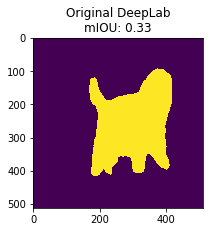

In [16]:
# for i in range(image_count):
  im = image_batch[1].astype('uint8')
  gt = label_batch[1].reshape(sz).astype('int32')

  plt.figure(figsize=(14,10))
  plt.subplot(141)

  plt.imshow(preds1[1])
  plt.imshow(image_batch[1].astype('uint8'), alpha=0.0)
  # plt.imshow(preds1, alpha=0.5)
  plt.title('Original DeepLab\nmIOU: '+str(mIOU(gt, preds1)))

##Visualize Prediction

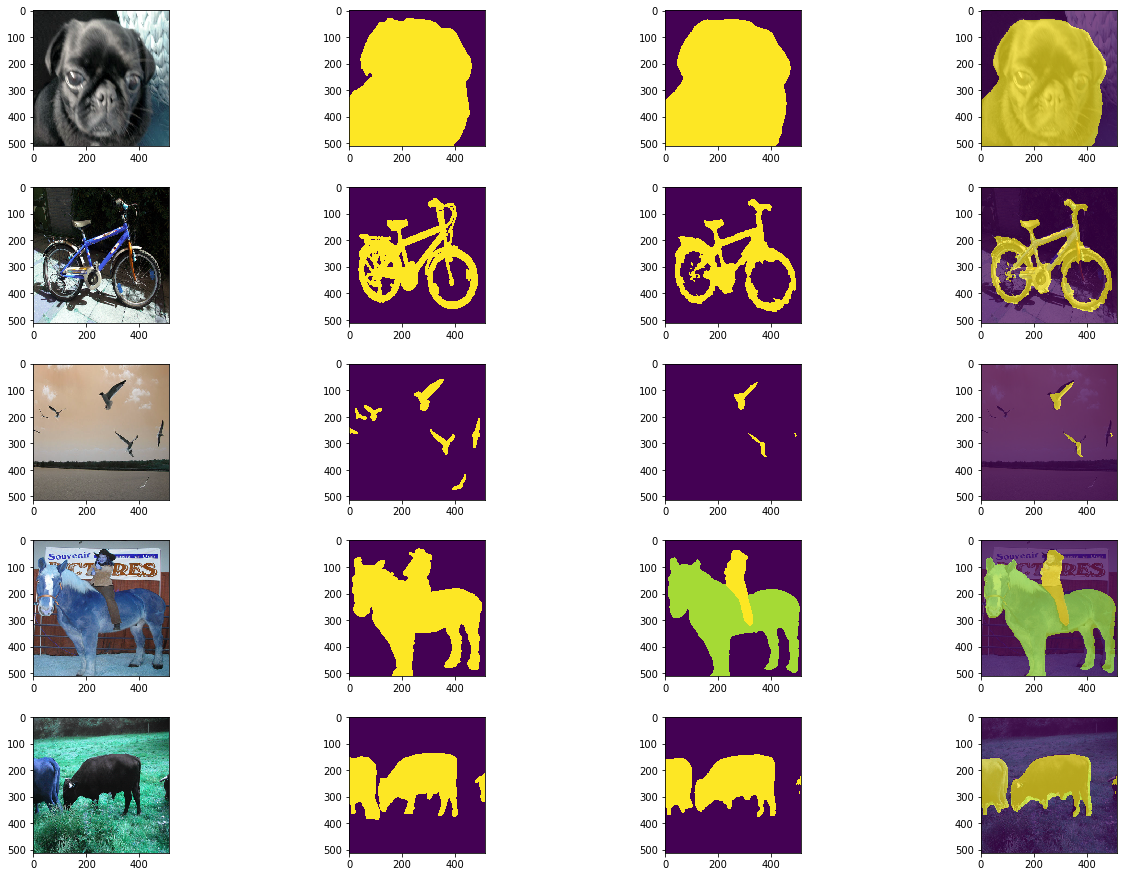

In [30]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import gridspec
w = 512
h =512
fig = plt.figure(figsize=(26,13))
gs = gridspec.GridSpec(5, 4, width_ratios=[1, 1, 1, 1],
         wspace=0.0, hspace=0.3, top=0.95, bottom=0.05, left=0.17, right=0.845) 
# f, axarr = plt.subplots(5,3,figsize=(26,13))
id =0
for i in np.random.choice(100, 5, replace=False):
  true_lab = np.asarray(label_batch[i].astype('uint8'))
  true_lab = true_lab.reshape(w,h)
  ori = np.array(Image.fromarray(image_batch[i].astype('uint8')).resize((w, h)))
  target = np.array(Image.fromarray(true_lab).resize((w, h)))
  pred = np.array(Image.fromarray(preds1[i].astype('uint8')).resize((w, h)))
  

  ax= plt.subplot(gs[id,0])
  ax.imshow(ori)

  ax= plt.subplot(gs[id,1])
  ax.imshow(target)

  ax= plt.subplot(gs[id,2])
  ax.imshow(pred)

  ax= plt.subplot(gs[id,3])
  ax.imshow(pred)
  ax.imshow(ori, cmap='jet', interpolation='none', alpha=0.3)

  id = id +1

## References

1. https://arxiv.org/pdf/1802.02611v3.pdf
2. https://github.com/bonlime/keras-deeplab-v3-plus
3. https://github.com/Golbstein/Keras-segmentation-deeplab-v3.1
4. https://github.com/tensorflow/models/tree/master/research/deeplab
5. https://www.analyticsvidhya.com/blog/2019/02/tutorial-semantic-segmentation-google-deeplab/
6. https://github.com/amiltonwong/mil-keras-deeplab-v3-plus
7. https://github.com/MLearing/Keras-Deeplab-v3-plus
8. https://github.com/mjDelta/deeplabv3plus-keras
9. https://towardsdatascience.com/review-deeplabv3-atrous-convolution-semantic-segmentation-6d818bfd1d74
10. https://www.novatec-gmbh.de/blog/semantic-segmentation-part-1-deeplab-v3/
11. https://github.com/jeffery-zhougang/DeeplabV3Plus-Keras-Retraining
12. https://github.com/mathildor/DeepLab-v3/blob/master/model.py
